# PixMeshes



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

### Landscape



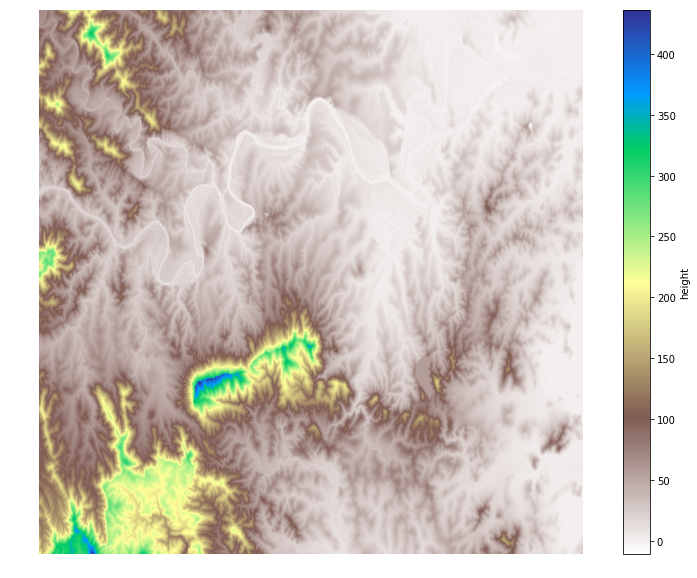

In [40]:
dem = imread('data/port_macquarie.tif', mode='F')

rows, columns = dem.shape
aspect_ratio = float(columns) / float(rows)

spacing = 5.0

minX, maxX = 0.0, spacing*dem.shape[1]
minY, maxY = 0.0, spacing*dem.shape[0]


fig = plt.figure(1, figsize=(10*aspect_ratio,10))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow(dem, cmap='terrain_r', origin='upper', aspect=aspect_ratio)
fig.colorbar(im, ax=ax, label='height')

In [3]:
dem.shape

(3612, 5124)

## PixMesh

Now the points can be triangulated to become a quality unstructured mesh.

Triangulation reorders x,y points - be careful!

In [4]:
from quagmire import FlatMesh 
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh

DM = meshtools.create_DMDA(0.0, 5124.0, 0.0, 3612.0, 5124/2, 3612/2 )

In [5]:
mesh = SurfaceProcessMesh(DM)

 - Construct neighbour array 5.535717s
 - cKDTree 21.030591s
 - Find boundaries 0.030571s
 - Build smoothing matrix 0.991946s
 - Construct neighbour cloud array 16.988508s
 - Construct rbf weights 6.784108s


In [6]:
# Triangulation reorders points

# coords = np.stack((mesh.tri.points[:,1], mesh.tri.points[:,0])).T / spacing
# meshheights = ndimage.map_coordinates(dem, coords.T, order=3, mode='nearest')
# meshheights = np.maximum(0.0, meshheights)

print mesh.neighbour_array.shape
print mesh.coords.shape
print dem[::2,::2].shape

(4626972,)
(4626972, 2)
(1806, 2562)


In [7]:
mesh.update_height(dem[::2,::2].reshape(-1))

 - Sort nodes by field 13.099606s
 - Build downhill matrices 16.437185s


In [8]:
flowpaths = mesh.cumulative_flow(np.ones_like(mesh.height))

low_points = mesh.identify_low_points()

print low_points.shape[0]

# for i in range(0, 10):
#     meshheights = mesh.handle_low_points(0.0, 20)
#     mesh.update_height(meshheights)
#     low_points = mesh.identify_low_points()
#     print low_points.shape[0]


49678


In [23]:
manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height, axis=1)


In [38]:
from LavaVu import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

topo = lv.points(pointsize=1.0, pointtype='flat')
topo.vertices(manifold)
# topo.values(mesh.height, label='height')
topo.values(flowpaths, label='flow')
topo.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=True)   # Apply a built in colourmap



0

In [39]:
## Viewer

lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import stripy

# coords = dm1.getCoordinatesLocal().array.reshape(-1,2)
# coords += np.random.random(coords.shape) * 0.01

# tri = stripy.Triangulation(coords[:,0], coords[:,1])


In [ ]:
# fig = plt.figure(1, figsize=(10*aspect_ratio,10))
# ax = fig.add_subplot(111)
# ax.axis('off')
# im1 = ax.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, mesh.height, linewidth=0.1, cmap='jet')
# fig.colorbar(im1, ax=ax, label='slope')
# plt.show()

Landscape analysis statistics

In [ ]:
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.001)[0]
low_points = mesh.identify_low_points()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(np.logical_and(mesh.down_neighbour1 == nodes, mesh.height > 0.5))[0]

# print statistics
print("mean gradient {}\nnumber of flat spots {}\nnumber of low points {}".format(gradient_mean,
                                                                                  flat_spots.size,
                                                                                  low_points.shape[0]))

In [ ]:
filename = 'port_macquarie_mesh.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height=mesh.height, slope=mesh.slope, flow=np.sqrt(flow))

# to view in Paraview
meshtools.generate_xdmf(filename)